# 주택 가격 예측 문제

# 1. 필요 패키지 임포트 및 데이터 불러오기

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import warnings
warnings.filterwarnings("ignore")

# visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette('Set2')
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# analysis
from scipy.stats import norm
from scipy import stats

# modelling
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM_SEED = 2021

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/enode6/kaggle_kakr_housing/data/'
train_path = dir_path+'train.csv'
test_path = dir_path+'test.csv'

In [3]:
def load_data():
    return pd.read_csv(train_path), pd.read_csv(test_path)

In [4]:
train, test = load_data()

- train 데이터는 정답 데이터 포함 21개 컬럼으로 구성되어 있고
- test 데이터는 20개 컬럼으로 구성되어 있다.

In [5]:
print(f'train data shape : {train.shape}')
print(f'test data shape : {test.shape}')

train data shape : (15035, 21)
test data shape : (6468, 20)


# 2. 데이터 분석하기

### 2-1. 컬럼 분석

In [43]:
train.apply(lambda x:min(x))

id                          0.000000
price                   78000.000000
bedrooms                    0.000000
bathrooms                   0.000000
sqft_living               290.000000
floors                      1.000000
waterfront                  0.000000
view                        0.000000
condition                   1.000000
grade                       1.000000
sqft_above                290.000000
sqft_basement               0.000000
yr_built                    0.000000
zipcode                 98001.000000
lat                        47.155900
long                     -122.519000
sqft_living15             399.000000
min_haver                   0.000000
date(new)                 102.000000
how_old                    -1.000000
sqft_total_size           290.000000
sqft_diff               -8690.000000
sqft_living_lot_diff    -1900.000000
sqft_bedrooms             122.500000
zip_12                      0.000000
std                        27.023036
mean                      146.575387
c

In [44]:
train.apply(lambda x:max(x))

id                      1.503400e+04
price                   7.700000e+06
bedrooms                1.000000e+01
bathrooms               8.000000e+00
sqft_living             1.354000e+04
floors                  3.500000e+00
waterfront              1.000000e+00
view                    4.000000e+00
condition               5.000000e+00
grade                   1.300000e+01
sqft_above              9.410000e+03
sqft_basement           4.130000e+03
yr_built                1.150000e+02
zipcode                 9.819900e+04
lat                     4.777760e+01
long                   -1.213150e+02
sqft_living15           6.210000e+03
min_haver               2.265697e+01
date(new)               1.314000e+03
how_old                 1.150000e+02
sqft_total_size         1.354000e+04
sqft_diff               2.310000e+03
sqft_living_lot_diff    1.650059e+06
sqft_bedrooms           1.721429e+03
zip_12                  1.900000e+01
std                     1.236932e+02
mean                    5.551714e+02
c

|컬럼명|설명|범위|
|---|---|---|
|id|집 고유번호|0~15034|
|date|집 구매 날짜|20140502~20150514|
|price|집 가격 ➡ Target Value|780000~7700000|
|bedrooms|침실 개수|0~10|
|bathrooms|화장실 개수(`0.5`:세면대,화장실 `0.75`:+샤워실 `1.0`:+욕조)|0.0~8.0|
|sqft_living|주거 공간 평방 피트|290~13540|
|sqft_lot|부지 평방 피트|520~1651359|
|floors|집 층수 (`0.5` : 다락방)|1.0~3.5|
|waterfront|집 전방에 강이 있는지 여부|0,1|
|view|집이 좋아보이는 정도|0~4|
|condition|집의 전반적인 상태|1~5|
|grade|King County Grading 시스템 기준으로 매긴 집의 등급|1~13|
|sqrt_above|지하실을 제외한 평방 피트|290~9410|
|sqrt_basement|지하실 평방 피트|0~4130|
|yr_built|건축년도|1900~2015|
|yr_renovated|재건축년도|0~2015|
|zipcode|우편번호|98001~98199|
|lat|위도|47.1559~47.7776|
|long|경도|-122.519~-121.315|
|sqrt_living15|2015년 기준 주거 공간 평방 피트|399~6210|
|sqrt_lot15|2015년 기준 부지 평방 피트|651~871200|
> 15년 기준 측정면적인지 해당 집 주변 이웃 15곳의 평균치인지 논란
> 재건축 시 sqrt_living, sqrt_lot에 비해 변동 가능

> 15년 기준 측정면적이라기엔 최소값 최대값 차이가 있는 편

- 비연속형 변수 : `waterfront`, `bedrooms`, `bathrooms`, `floors`, `view`, `condition`, `grade`, `yr_built`, `yr_renovated`, `zipcode`
- 연속형 변수 : `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `lat`, `long`, `sqft_living15`, `sqft_lot15`

### 2-2.결측치 및 자료형 확인 및 unique 값
- `date`를 제외하고는 다 수치형 데이터이다.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

- 결측치는 따로 없다.

<AxesSubplot:>

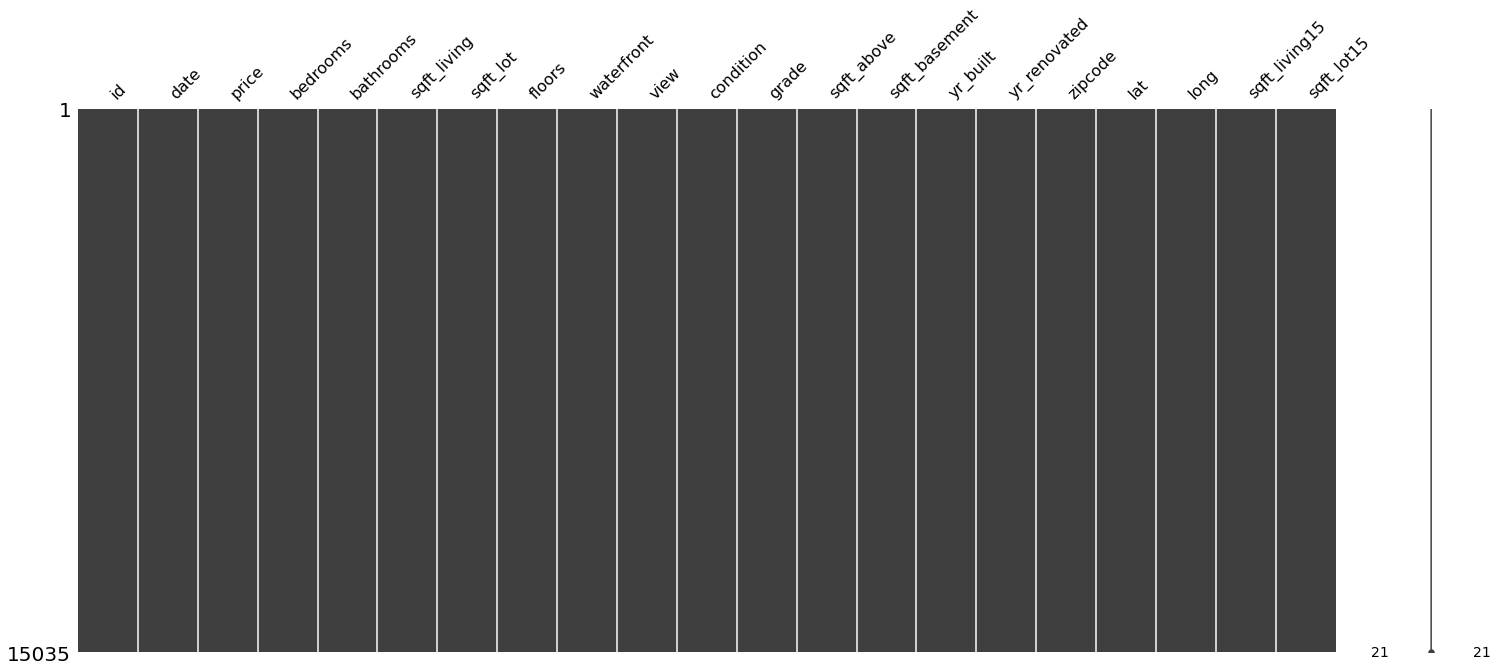

In [8]:
msno.matrix(train)

In [9]:
print(f'     column   |  unique value')
print('==============================')
for col in train.columns:
    print(f'{col.rjust(13)} |  {train[col].nunique()}')

     column   |  unique value
           id |  15035
         date |  365
        price |  3263
     bedrooms |  11
    bathrooms |  29
  sqft_living |  863
     sqft_lot |  7678
       floors |  6
   waterfront |  2
         view |  5
    condition |  5
        grade |  12
   sqft_above |  789
sqft_basement |  271
     yr_built |  116
 yr_renovated |  65
      zipcode |  70
          lat |  4692
         long |  716
sqft_living15 |  682
   sqft_lot15 |  6958


### 2-3. 연속형 변수 분포 확인

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

Text(0.5, 1.0, 'sqft_living')

<AxesSubplot:xlabel='sqft_lot', ylabel='Density'>

Text(0.5, 1.0, 'sqft_lot')

<AxesSubplot:xlabel='sqft_above', ylabel='Density'>

Text(0.5, 1.0, 'sqft_above')

<AxesSubplot:xlabel='sqft_basement', ylabel='Density'>

Text(0.5, 1.0, 'sqft_basement')

<AxesSubplot:xlabel='lat', ylabel='Density'>

Text(0.5, 1.0, 'lat')

<AxesSubplot:xlabel='long', ylabel='Density'>

Text(0.5, 1.0, 'long')

<AxesSubplot:xlabel='sqft_living15', ylabel='Density'>

Text(0.5, 1.0, 'sqft_living15')

<AxesSubplot:xlabel='sqft_lot15', ylabel='Density'>

Text(0.5, 1.0, 'sqft_lot15')

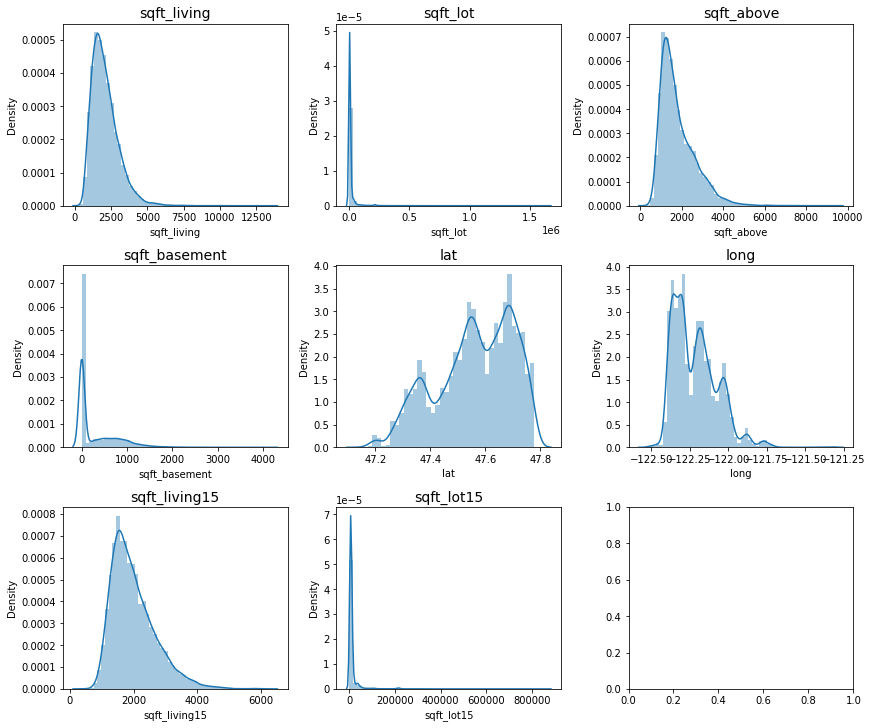

In [10]:
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
fig, ax = plt.subplots(3,3, figsize=(12,10), constrained_layout=True)
count = 0
for row in range(3):
    for col in range(3):
        if count == len(continuous): break
        sns.distplot(train[continuous[count]], ax=ax[row][col])
        ax[row][col].set_title(continuous[count],fontsize=14)
        count +=1
plt.show()

- 치우친 변수들 : `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`,`sqft_living15`, `sqft_lot15`

로그 변환하자.

### 2-4. 비연속형 변수 분포 확인
- 유니크한 값 개수 세기
- 날짜 변수 전처리 : `date` 대신 `year`나 `month` 사용

In [11]:
for df in [train, test]:
    df['date'] = df['date'].apply(lambda x : str(x[:8])).astype(str)
    df['yearmonth'] = df['date'].apply(lambda x : x[:6]).astype(int)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    del df['date']

<AxesSubplot:xlabel='waterfront', ylabel='count'>

Text(0.5, 1.0, 'waterfront')

<AxesSubplot:xlabel='waterfront', ylabel='price'>

Text(0.5, 1.0, 'price by waterfront')

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

Text(0.5, 1.0, 'bedrooms')

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

Text(0.5, 1.0, 'price by bedrooms')

<AxesSubplot:xlabel='bathrooms', ylabel='count'>

Text(0.5, 1.0, 'bathrooms')

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

Text(0.5, 1.0, 'price by bathrooms')

<AxesSubplot:xlabel='floors', ylabel='count'>

Text(0.5, 1.0, 'floors')

<AxesSubplot:xlabel='floors', ylabel='price'>

Text(0.5, 1.0, 'price by floors')

<AxesSubplot:xlabel='view', ylabel='count'>

Text(0.5, 1.0, 'view')

<AxesSubplot:xlabel='view', ylabel='price'>

Text(0.5, 1.0, 'price by view')

<AxesSubplot:xlabel='condition', ylabel='count'>

Text(0.5, 1.0, 'condition')

<AxesSubplot:xlabel='condition', ylabel='price'>

Text(0.5, 1.0, 'price by condition')

<AxesSubplot:xlabel='grade', ylabel='count'>

Text(0.5, 1.0, 'grade')

<AxesSubplot:xlabel='grade', ylabel='price'>

Text(0.5, 1.0, 'price by grade')

<AxesSubplot:xlabel='year', ylabel='count'>

Text(0.5, 1.0, 'year')

<AxesSubplot:xlabel='year', ylabel='price'>

Text(0.5, 1.0, 'price by year')

<AxesSubplot:xlabel='month', ylabel='count'>

Text(0.5, 1.0, 'month')

<AxesSubplot:xlabel='month', ylabel='price'>

Text(0.5, 1.0, 'price by month')

<AxesSubplot:xlabel='yearmonth', ylabel='count'>

Text(0.5, 1.0, 'yearmonth')

<AxesSubplot:xlabel='yearmonth', ylabel='price'>

Text(0.5, 1.0, 'price by yearmonth')

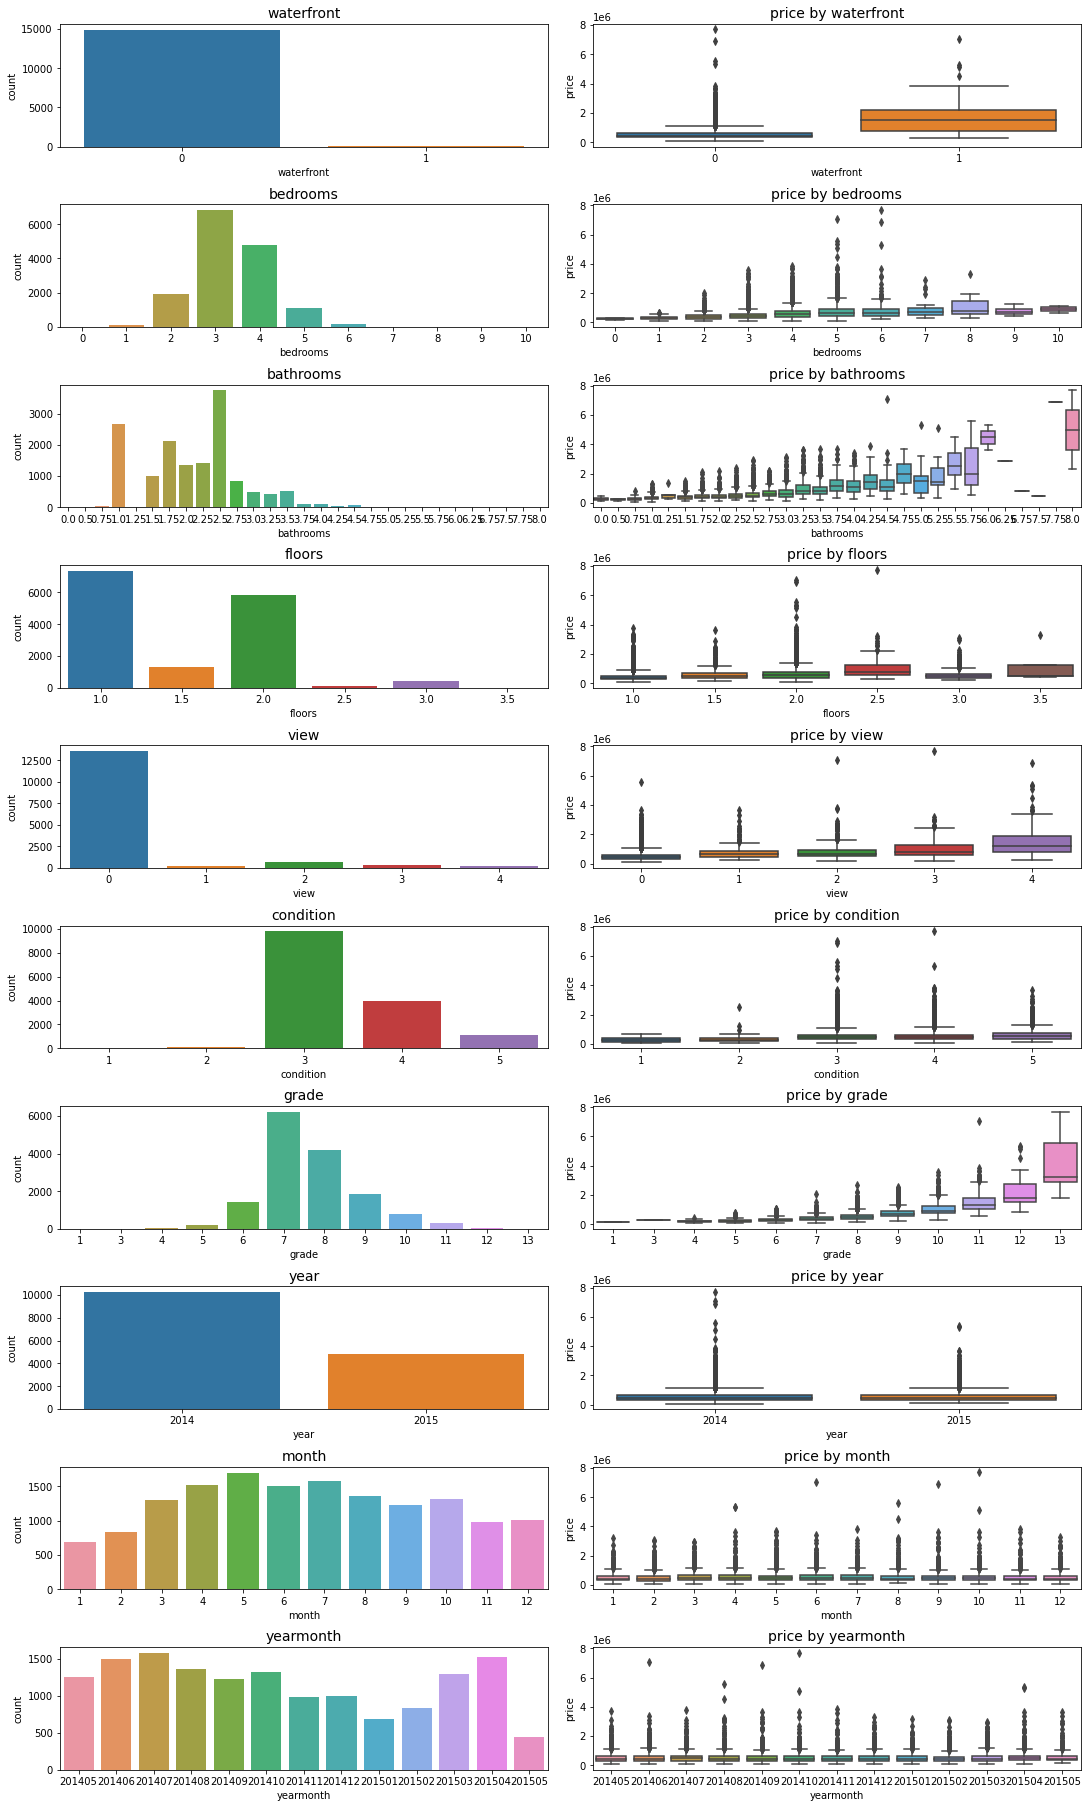

In [12]:
categoric = ['waterfront', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition','grade','year', 'month', 'yearmonth']
fig, ax = plt.subplots(10,2, figsize=(15,25), constrained_layout=True)

for row in range(len(categoric)):
    sns.countplot(train[categoric[row]], ax=ax[row][0])
    ax[row][0].set_title(categoric[row],fontsize=14)
    sns.boxplot(x=categoric[row],y='price', data=train, ax=ax[row][1])
    ax[row][1].set_title(f'price by {categoric[row]}',fontsize=14)

plt.show()

- `waterfront` 가 1 인 집은 거의 없다. 14928 : 107의 비율
    - 그에 비해 `waterfront` 여부에 따른 가격차는 있는 편이다. 하지만 데이터가 워낙 불균형하다보니 가장 높은 가격은 `waterfront`가 아닌 경우에 존재한다.
- `bedrooms`는 2~5에 집중적으로 분포하는 모습을 보였다.
    - 가격별 분포를 보면 확실히 정비례 관계를 보이긴 하나 6 이상의 데이터가 얼마 없어 고액의 주택은 5~6에 대거 분포하고 있다.
- `bathrooms`는 대부분의 집이 1.0~4.0 사이에 분포하고 있다.
    - 아무래도 `bathrooms` 수치가 크려면 방도 여러 개 있어야하므로 `bathrooms`에 따른 가격 역시 비례 관계를 보이는 편이다.
    - 가장 고액의 주택은 4.25에 분포한다.
    - `(화장실 개수/침실 개수)`라고 많은 커널에서 설명하고 있었는데 8.0이 되려면 방도 없는데 화장실만 여러 개 있는건가..?
    - 0.5 : 세면대, 화장실
    - 0.75 : 세면대, 화장실, 샤워실
    - 1.0 : 세면대, 화장실, 샤워실, 욕조
    - 라고 하는 설명이 더 설득력 있는 것 같다.
- `floors`는 1.0,2.0이 월등히 많았다.
    - 대부분의 표본이 몰려있기도 하고 1개 층에 넓은 면적을 가지고 있는 경우도 많기 때문에 가격과 뚜렷한 비례관계는 보이지 않는다.
- `view`는 대부분이 0이다.
    - 하지만 주택 개수 분포가 적음에도 가격은 view가 높을 수록 전반적으로 높았다.
- `condition`은 대부분 3~5에 분포해 있다.
    - 가격의 전반적인 분포도 어느 정도 비례하여 condition이 높은 값일 수록 고액의 주택이 많았다.
- `grade`는 6~9 사이에 많이 분포하고 있었다.
    - 11~13은 적은 주택이 분포하고 있음에도 가격과 비례하는 모습을 볼 수 있다.
- `yearmonth`는 201505와 201501이 상대적으로 적은 거래수를 보이고 있다. 

In [13]:
train.groupby('waterfront').count()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yearmonth,year,month
waterfront,,,,,,,,,,,,,,,,,,,,,
0,14928,14928,14928,14928,14928,14928,14928,14928,14928,14928,...,14928,14928,14928,14928,14928,14928,14928,14928,14928,14928
1,107,107,107,107,107,107,107,107,107,107,...,107,107,107,107,107,107,107,107,107,107


In [14]:
pd.set_option('display.max_columns', 40)
train.iloc[:,2:4].groupby('bathrooms').count().T

bathrooms,0.00,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.75,7.50,7.75,8.00
bedrooms,4,3,45,2675,5,1009,2112,1357,1433,3748,843,493,410,510,108,100,57,64,16,14,11,7,3,2,1,1,1,1,2


In [15]:
train.iloc[:,[1,-3]].groupby('yearmonth').max().T

yearmonth,201405,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503,201504,201505
price,3710000.0,7062500.0,3800000.0,5570000.0,6885000.0,7700000.0,3850000.0,3300000.0,3200000.0,3065000.0,2945000.0,5350000.0,3650000.0


In [16]:
train.iloc[:,[1,-3]].groupby('yearmonth').count().T

yearmonth,201405,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503,201504,201505
price,1252,1500,1582,1361,1227,1322,981,1004,691,842,1300,1525,448


### 2-5. 목적변수 분석

<Figure size 432x432 with 0 Axes>

<AxesSubplot:xlabel='price', ylabel='Density'>

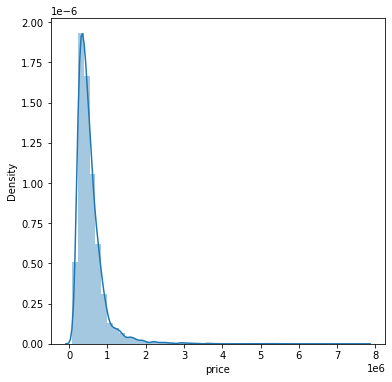

In [17]:
plt.figure(figsize=(6,6))
sns.distplot(train['price'])
plt.show()

- 왼쪽으로 많이 치우쳐 있는 것을 볼 수 있다.
- 정규분포를 가지도록 로그 변환을 취해주자.

### 2-6. 목적변수와의 상관관계 행렬

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

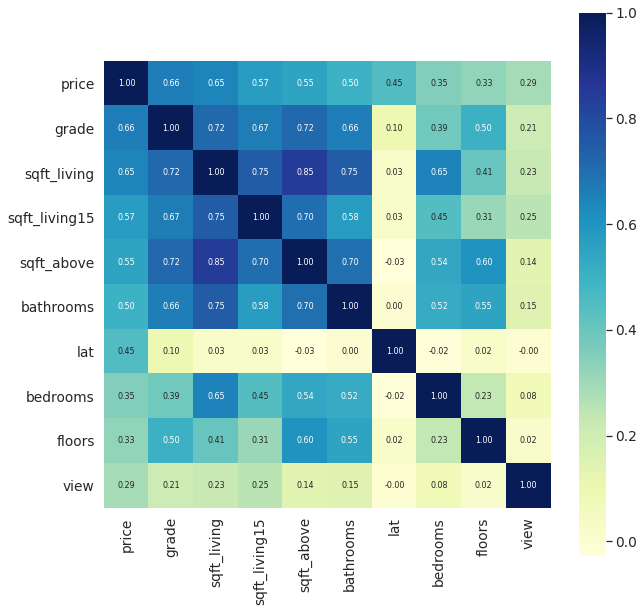

In [18]:
corr_abs = abs(train.corr(method='spearman'))
corr_cols = corr_abs.nlargest(n=10, columns='price').index
corr = np.array(stats.spearmanr(train[corr_cols].values))[0] # 10 x 10
print(corr_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(corr, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=corr_cols.values, yticklabels=corr_cols.values,cmap="YlGnBu")

- `price`와 큰 연관성을 보인 것은 `grade`, `sqft_living` 이다.

### 2-7. 지역 관련 변수
- 위도, 경도로 거리를 구하자.

- def `haversine_array(lat2, lng2)`
    

In [ ]:
def haversine_array(lat2, lng2):
    lat1, lng1 = 47.63, -122.22
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def haversine_array_new(lat1_raw, lng1_raw, lat2, lng2):
    lat1, lng1 = lat1_raw, lng1_raw
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def haversine_array_low(lat2, lng2):
    lat1, lng1 = 47.382, -122.247
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


### 위도,경도 - 가격 산포

<Figure size 720x504 with 0 Axes>

([<matplotlib.axis.YTick at 0x7f79806fb5d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

([<matplotlib.axis.XTick at 0x7f79881ce890>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

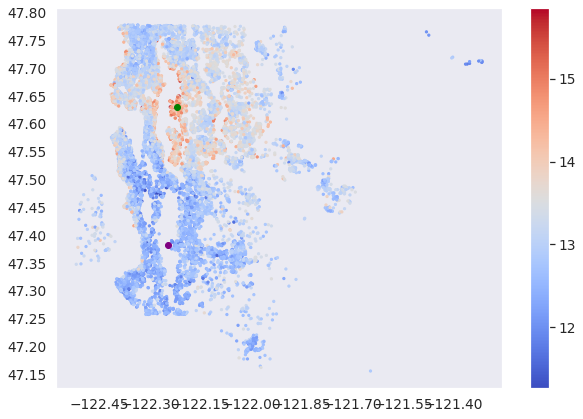

In [46]:
plt.figure(figsize=(10,7))
plt.scatter(data['long'], data['lat'], s=5, c=np.log1p(data['price']), cmap='coolwarm')
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(color='#BDBDBD', linestyle='-', linewidth=0.5)
plt.colorbar()
plt.scatter(-122.22, 47.63, color='green')
plt.scatter(-122.247, 47.382, color='purple')

- 매매가가 높은 주택이 몰려 있는 곳에 중심점을 하나 잡고, 매매가가 낮은 주택이 밀집해 있는 곳의 중심점을 하나 잡았다.

# 3. 데이터 전처리 및 피처 엔지니어링

### 3-1. min_haver
- 이웃 중 가장 가까운 곳과의 거리

In [ ]:
train, test = load_data()
train_len = len(train)
data = pd.merge(train,test, how='outer')

data['min_haver'] = np.nan
for i in range(len(data)) :
    temp_lat, temp_lng = data[['lat', 'long']].loc[i,'lat'], data[['lat', 'long']].loc[i,'long']
    temp_all_df = data.drop([i], 0)
    temp_coord_df = haversine_array_new(temp_lat, temp_lng, temp_all_df['lat'], temp_all_df['long'])
    temp_min = temp_coord_df.min()
    data.loc[i,'min_haver'] = temp_min    
train = data.iloc[:train_len,:]
test = data.iloc[train_len:,:]

### 3-2. `zipcode` 파생변수 유도

In [ ]:
### zipcode

le = LabelEncoder()
for df in [train, test]:
    ### zipcode
    df['zip_12'] = df['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)
    le.fit_transform(df['zipcode'])
    
# zipcode group by 단가
train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()
train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')
del train['price_per_land_area']

### 3-4. 날짜 및 건설년도 관련 파생변수 유도

In [ ]:
for df in [train, test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1) # 얼마나 됐는지 연식
    df['yr_built'] = df['yr_built'] - 1900 # 건축년도 1900년도로부터 얼마나 됐는지 

### 3-5. 건물 면적 관련 파생변수 유도

In [ ]:
for df in [train, test]:    
     # 총 주택 면적 (지상+지하)
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] 
    
    # 15년 기준 주거공간 면적
    df['sqft_diff'] = df['sqft_living15'] - df['sqft_living']
    df['sqft_living_lot_diff'] = df['sqft_lot'] - df['sqft_living']
    del df['sqft_lot15'], df['yr_renovated'], df['sqft_lot'],df['date']
    
    # 총 침실 면적
    df['sqft_bedrooms'] = df['sqft_total_size'] / (df['bedrooms'] + 1) 

### 3-6. train x, y, test  분리

In [ ]:
### 학습용 데이터   
train_x = train.drop(['id','price'], axis=1)
train_y = np.log1p(train['price'])
test_x = test.drop(['id','price'], axis=1)

### 3-7. KMeans 군집화로 위도, 경도, 가격 묶기
- 120개의 클러스터로 군집화했다.

In [ ]:
####### KMeans Clustering
km_n = 120
km = KMeans(n_clusters=km_n, random_state=2019)
km.fit(train_x[['lat', 'long']])#
for df in [train_x, test_x]:
    km_col_name = 'km'+ '_' + str(km_n)
    df[km_col_name] = km.predict(df[['lat', 'long']])

- 실제 가격별 군집화된 결과

<Figure size 720x504 with 0 Axes>

([<matplotlib.axis.YTick at 0x7f7a11aebd90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

([<matplotlib.axis.XTick at 0x7f7a11ae6f90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

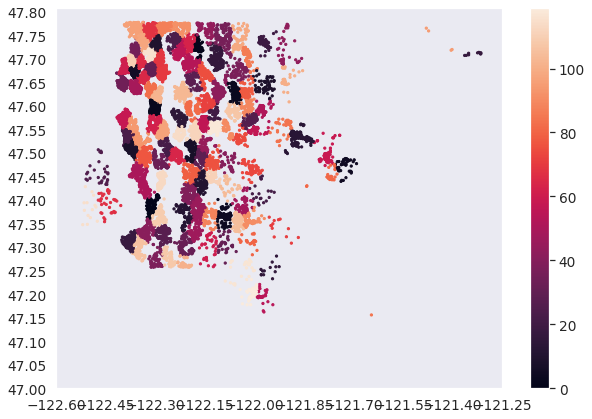

In [52]:
plt.figure(figsize=(10,7))
plt.scatter(train_x['long'], train_x['lat'], s=5, c=train_x['km_120'])
plt.yticks(np.arange(47, 47.81, 0.05))
plt.xticks(np.arange(-122.6, -121.2, 0.15))
plt.grid(linestyle='-', linewidth=0.5)
plt.colorbar()

### 3-8. `grade`, `view`, `condition` 등 등급 관련 파생변수
- `sum_level` : `grade` + `view` + `condition`
- `multi_level` : `grade` \*  `view` \*  `condition`
- `sum_level_2` : `view` + `condition(3미만인 것은 0으로 치환)` + `grade`
- `low_all` : `condtion(2이하는 0, 나머지는 1)` + `view(0인것은 0 나머지는 1)` + `bath(1미만은 0 나머지는 1)` + `bed(1이면 0 나머지는 1)` + `grade(6이하면 0, 나머지는 1)` + `waterfront`
- 여러 종류의 등급들을 합하거나 곱해서 파생변수를 만들었다.
- 등급이 낮은 변수들을 0으로 묶어 일정 등급 이상의 등급의 영향이 더 커지도록 하였다.

In [ ]:
# 레벨 관련    
for df in [train_x, test_x]:    
    df['sum_level'] = df['grade'] + df['view'] + df['condition'] # 등급 총합
    df['multi_level'] = df['grade'] * (df['view']+1) * df['condition']
    
    df['condition_2'] = df['condition'].apply(lambda x : 0 if x < 3 else x)
    df['sum_level_2'] = df['view'] + df['condition_2'] + df['grade']
    
    del df['condition_2']
    
    df['low_cond']=df['condition'].apply(lambda x : 0 if x <= 2 else 1)
    df['low_view'] = df['view'].apply(lambda x : 0 if x == 0 else 1)
    df['low_bath'] = df['bathrooms'].apply(lambda x: 0 if x < 1 else 1)
    df['low_bed'] = df['bedrooms'].apply(lambda x : 0 if x ==1 else 1)
    df['low_grade'] = df['grade'].apply(lambda x : 0 if x <= 6 else 1)
    df['low_all'] = (df['low_cond'] + df['low_view']+df['low_bath'] + df['low_bed'] + df['low_grade']) + df['waterfront']
    
    del df['low_cond'], df['low_view'], df['low_bath'], df['low_bed'], df['low_grade']

### 3-9. 중심점으로부터의 거리
- 2-7에서 잡은 중심점으로 부터의 거리
- `haversine_dist` : 집값이 높은 중심점 `(47.63, -122.22)`으로부터의 거리
- `haversine_dist_low` : 집값이 낮은 중심점 `(47.382, -122.247)`으로부터의 거리

In [ ]:
# 거리 관련
for df in [train_x, test_x]: 
    df['haversine_dist']= haversine_array(df['lat'], df['long']) # 중심가로부터의 거리 (haversine_dist)
    df['haversine_dist_low'] = haversine_array_low(df['lat'], df['long'])

### 3-10. 치우친 변수 로그 변환

In [25]:
# 치우친 변수 로그 변환
for i in ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_total_size', 'sqft_bedrooms'] :
    train_x[i] = np.log1p(train_x[i])
    test_x[i] = np.log1p(test_x[i])
    

train_x = train_x.drop([13522, 4123],0)
train_y = train_y.drop([13522, 4123],0)

train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

array([66, 16, 37, ..., 42, 60, 59])

array([55, 58, 29, ..., 50, 59, 15])

KMeans(n_clusters=120, random_state=2019)

# 4. 모델링
### 4-1. 도우미 함수
- def `rmse_exp(predictions, dmat)`
    - 학습 결과 RMSE로 평가
- def `save_submission(model, train, y, test, model_name, rmsle)`
    - 예측 결과 .csv 파일로 저장

In [34]:
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

### 4-2. train, test 데이터 확인

In [48]:
train_x.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,min_haver,date(new),how_old,sqft_total_size,sqft_diff,sqft_living_lot_diff,sqft_bedrooms,zip_12,std,mean,count,km_120,sum_level,multi_level,sum_level_2,low_all,haversine_dist,haversine_dist_low
0,3,1.00,7.074117,1.0,0,0,3,7,7.074117,0.0,55,98178,47.5112,-122.257,7.201171,0.044478,613,59,7.074117,160,4470,5.690359,17,75.193536,189.965938,192,22,10,21,10,4,13.498442,14.386052
1,2,1.00,6.647688,1.0,0,0,3,6,6.647688,0.0,33,98028,47.7379,-122.233,7.908755,0.143364,1025,82,6.647688,1950,9230,5.551667,2,51.267030,222.523551,201,24,9,18,9,3,12.037335,39.588215
2,3,2.00,7.427144,1.0,0,0,3,8,7.427144,0.0,87,98074,47.6168,-122.045,7.496097,0.011119,1018,28,7.427144,120,6400,6.042633,7,65.381676,267.018622,295,3,11,24,11,4,13.197328,30.198213
3,3,2.25,7.447751,2.0,0,0,3,7,7.447751,0.0,95,98003,47.3097,-122.327,7.713785,0.143684,227,19,7.447751,523,5104,6.063204,0,31.815332,157.972739,185,106,10,21,10,4,36.512528,10.047953
4,3,1.50,6.966967,1.0,0,0,3,7,6.966967,0.0,63,98198,47.4095,-122.315,7.409136,0.078469,915,52,6.966967,590,8651,5.583496,19,65.707370,179.067611,198,51,10,21,10,4,25.535241,5.962297


In [49]:
test_x.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,min_haver,date(new),how_old,sqft_total_size,sqft_diff,sqft_living_lot_diff,sqft_bedrooms,zip_12,std,mean,count,km_120,sum_level,multi_level,sum_level_2,low_all,haversine_dist,haversine_dist_low
0,3,2.25,7.852050,2.0,0,0,3,7,7.682943,5.993961,51,98125,47.7210,-122.319,7.433075,0.075627,809,23,7.852050,-880,4672,6.466922,12,79.989303,280.153454,294,116,10,21,10,4,12.543108,38.080394
1,4,3.00,7.581210,1.0,0,0,5,7,6.957497,6.814543,65,98136,47.5208,-122.393,7.215975,0.055597,809,49,7.581210,-600,3040,5.973810,13,96.875640,336.554976,179,23,12,35,12,4,17.772290,18.939902
2,4,4.50,8.598036,1.0,0,0,3,11,8.266421,7.333676,101,98053,47.6561,-122.005,8.468213,0.100304,112,13,8.598036,-660,96510,6.989335,5,60.199275,268.945226,284,78,14,33,14,4,16.366580,35.485133
3,3,1.00,7.484930,1.0,0,0,3,7,6.957497,6.594413,60,98146,47.5123,-122.337,7.484930,0.044478,1215,55,7.484930,0,5690,6.100319,14,85.597885,223.377191,190,77,10,21,10,4,15.758447,15.991418
4,3,2.50,7.544861,2.0,0,0,3,7,7.544861,0.000000,103,98038,47.3684,-122.031,7.779467,0.077836,1112,12,7.544861,500,4670,6.160152,3,35.660810,172.558549,420,91,10,21,10,4,32.368760,16.335074


### 4-3. 모델 학습
- LGBMRegressor와 XGBoostRegressor를 사용해 학습했다.
- 둘 다 folds 수를 5로 해 교차검증을 진행했다.

In [28]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective':'regression',
    'num_leaves' : 3,
    'learning_rate' : 0.03,
    'max_depth' : 6,
    'colsample_bytree' : 0.4,
    'subsample' : 0.4,
    'max_bin' : 80,
    'metric' : 'rmse',
    'seed' : 2019
}
dtrain = lgb.Dataset(train_x, label=train_y)
dtest = lgb.Dataset(test_x)

cv_lgb_output = lgb.cv(lgb_params, dtrain, num_boost_round=5000, nfold=5, early_stopping_rounds=200, verbose_eval=100,stratified=False)
print('best_num_rounds :',len(cv_lgb_output['rmse-mean']))
print('best_cv_score :', cv_lgb_output['rmse-mean'][-1])

best_num_rounds = len(cv_lgb_output['rmse-mean'])

model_lgb = lgb.train(lgb_params, dtrain, num_boost_round=best_num_rounds)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 33
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 33
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number 

NameError: name 'X_test' is not defined

Best Rounds: 5000 Best CV Score : 0.16057656584507668

In [30]:
lgb_pred_log = model_lgb.predict(test_x)
lgb_pred = np.expm1(lgb_pred_log)

In [36]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',        
    'silent': True,               
    'seed' : 2019
}


# transform
dtrain = xgb.DMatrix(train_x, train_y)
dtest = xgb.DMatrix(test_x)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         
                   early_stopping_rounds=150,    
                   nfold=5,                      
                   verbose_eval=100,             
                   feval=rmse_exp,               
                   maximize=False,
                   show_stdv=False,              
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
xgb_pred_log = model.predict(dtest)
xgb_pred = np.expm1(xgb_pred_log)

[09:51:17] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:17] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:51:17] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:17] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:51:17] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squar

Best Rounds: 2793
Best Score: 107697.18

### 4-4. 학습 과정 시각화
- 과적합 없이 오차를 줄여가고 있는 것을 볼 수 있다.
- fold를 사용해서 RMSE의 평균을 시각화했다.

<AxesSubplot:>

Text(0.5, 1.0, 'RMSE_log')

<AxesSubplot:>

Text(0.5, 1.0, 'RMSE')

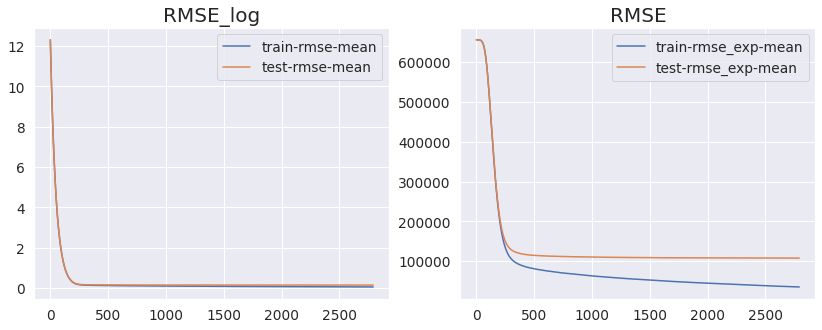

In [37]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()

### 4-5. 최종 스코어
- 최종 private score는 106795가 나왔다.
- 제출용 파일은 앞서 학습한 LGBM 모델과 XGB 모델의 예측결과를 산술평균한 값을 사용하였다.

![최종 스코어](submission_score.png)

In [40]:
def save_submission(lgb_pred,xgb_pred, nth):
    ensemble_pred = np.vstack([lgb_pred,xgb_pred]).mean(0)
    submission=pd.read_csv(dir_path+'sample_submission.csv')
    submission['price']=ensemble_pred
    submission.to_csv(f'xgb_lgb_{nth}_submission.csv',index=False)

In [41]:
save_submission(lgb_pred, xgb_pred, 2)

# 회고

- 파생 변수를 만드는 법은 끝이 없는 것 같다.
- 그래도 다양한 커널들을 보면서 변수 종류마다 주로 어떤 방법을 적용하는 것이 좋은 성적으로도 연결되는지 알 수 있었다.
- 범주형 변수가 목적 변수를 더 잘 표현할 수 있도록 분해하는 방법에 대해서 고민해볼 수 있었다.
   - `zipcode` 같은 경우는 사람이 의미를 가지고 부여한 번호이다.
   - 그리고 지역적 특성이 잘 녹아있는 변수다.
   - 5자리 숫자 중에서도 가격을 결정하는데 큰 영향을 미친 3,4번째 숫자를 사용했다.
   - 이런 범주형 데이터를 단순히 라벨인코딩 하기 보다는 한개, 두개, 세개 단위로 나누어보고 학습에 미치는 영향 정도를 파악해 봐야겠다.
- 위도, 경도에 따라 `KMeans`로 군집화 해보는 시도 역시 재밌었다. 아직 배운 지식들이 유연하게 튀어나오지는 않아서 좌표에 따른 군집화까지는 미처 생각하지 못했었다.
- 위도, 경도로 주어진 데이터를 다루어 본 것은 이번이 처음이었는데 정확한 최단 거리 계산을 위한 `haversine` 공식의 존재도 처음 알게 되었다.
- 전체 데이터에 영향을 적게 미치는 범주형 변수를 0으로 만들거나 여러개 범주형 변수를 더하거나 곱하는 것으로 더 정확도가 오르는 것도 신기했다.

# 참고한 커널

- [Let's EDA it](https://www.kaggle.com/junoindatascience/let-s-eda-it)
    - 연속형/비연속형 변수에서 상관관계 파악 `df.corr(method='spearman')`
    - 연속형/비연속형 변수 분포 확인
- [XGB, LGB 앙상블](https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble)
    - Feature Engineering
    - 앙상블